In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

import tqdm, time, os, datetime, glob, warnings, random
from sklearn.preprocessing import LabelEncoder
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
warnings.filterwarnings('ignore')

# 데이터 불러오기

In [2]:
root = 'C:/Users/fhsdn/Downloads/open'
train_df = pd.read_csv(f'{root}/train.csv')


In [3]:
train_df.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train= train_df.iloc[:,:6]

In [5]:
train.head()

,ID,제품,대분류,중분류,소분류,브랜드
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003


In [6]:
label_encoder = LabelEncoder()
categorical_columns = ['제품','대분류', '중분류', '소분류', '브랜드']


for col in categorical_columns:
    label_encoder.fit(train[col])
    train[col] = label_encoder.transform(train[col])

for col in categorical_columns:
    train[col] /= train[col].max()
train_x = torch.from_numpy(train.iloc[:,1:].values)
train_y = torch.from_numpy(train.iloc[:,:1].values)

In [7]:
print(train_x.shape)
print(train_y.shape)

torch.Size([15890, 5])
torch.Size([15890, 1])


In [8]:
print(train_x)


tensor([[0.0000e+00, 2.5000e-01, 6.0000e-01, 7.1154e-01, 0.0000e+00],
        [6.3135e-05, 5.0000e-01, 7.0000e-01, 8.2692e-01, 3.1556e-04],
        [1.2627e-04, 5.0000e-01, 7.0000e-01, 8.2692e-01, 3.1556e-04],
        ...,
        [9.9987e-01, 5.0000e-01, 7.0000e-01, 8.2692e-01, 1.0000e+00],
        [9.9994e-01, 5.0000e-01, 7.0000e-01, 8.2692e-01, 1.0000e+00],
        [1.0000e+00, 2.5000e-01, 3.0000e-01, 3.6538e-01, 1.0000e+00]],
       dtype=torch.float64)


# 데이터로더 작성

In [15]:
class forecast(Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self,idx):
        

        return self.x[idx,-1],self.x[idx,-1]

train_set = forecast(train_x,train_y)


In [16]:

ds = iter(train_set)


for i in range(1):
    input,output = next(ds)
    print(input.shape)
    print(output.shape)
    print(input)

    print(output)

torch.Size([])
torch.Size([])
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)


# 모델작성

In [32]:
class Embedding(nn.Module):
    def __init__(self, emb = 32):
        super(Embedding, self).__init__()

        self.Embedding = nn.Embedding(3170,emb)

        '''self.product = nn.Linear(emb,15840)
        self.big = nn.Linear(emb,5)
        self.middle = nn.Linear(emb,11)
        self.small = nn.Linear(emb,53)'''
        self.brand = nn.Linear(emb,3170)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        out = self.Embedding(x).squeeze(1)
        '''p = self.product(out)
        b = self.big(out)
        m = self.middle(out)
        s = self.small(out)'''
        out = self.dropout(out)
        br = self.brand(out)

        return br


# 학습

In [33]:
torch.cuda.empty_cache()
model = Embedding(4)

train_losses = []
lrs = []
min_epoch = 0
max_lr = 5e-3

batch_size = 512

model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),lr=max_lr)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.5 ** epoch)

In [34]:
epochs = 1000
model_save_path = f'{root}/model/'
train_loader = DataLoader(train_set, batch_size=batch_size,pin_memory=True, shuffle=True)

In [35]:

def train_begin(training,loader,running_loss):
    if training :
        desc = "Train"
    else:
        desc = "Valid"

    progress = tqdm.tqdm(loader,desc=f'Epoch:{epoch+1}/{epochs}')
    for i,data in enumerate(progress):
        x,y = data
        if (training):
            optimizer.zero_grad()

        x = x.to(device).long()
        y = y.to(device).long()

        br = model(x)

        #loss = criterion(p, y[:,0])+criterion(b, y[:,1])+criterion(m, y[:,2])+criterion(s, y[:,3])+criterion(br, y[:,4])
        loss = criterion(br, y)

        if (training):
            loss.backward()

            optimizer.step()

        running_loss += [loss.detach().cpu().numpy()]

        progress.set_description(f'Epoch:{epoch+1}/{epochs} | {desc}_Loss:{np.round(running_loss/(i+1),6)}')

In [36]:

fit_time = time.time()
start_epoch = len(lrs)

for i in range(len(train_losses)):
    print(f'Epoch:{i+1}/{epochs} | Train_Loss:{np.round(train_losses[i],4)}')
    print()

for epoch in range(start_epoch,epochs):

    '''if epoch % 150 == 0 and epoch >0 :
        scheduler.step()
        print("lr이 변경되었습니다.",optimizer.param_groups[0]['lr'])'''


    running_train_loss = np.array([0.0])
    running_valid_loss = np.array([0.0])

    model.train()
    train_begin(True,train_loader,running_train_loss)


    train_losses.append((running_train_loss/len(train_loader)))
    lrs.append(optimizer.param_groups[0]['lr'])

    if (os.path.exists(model_save_path)==False):
        os.makedirs(model_save_path,exist_ok=True)

    #torch.save(model, f'{model_save_path}Epoch({epoch+1}).pt')
    #np.save(model_save_path+'tl',train_losses)
    #np.save(model_save_path+'lrs',lrs)

    print('')

print('학습 최종 시간: {:.2f} 분\n' .format((time.time()- fit_time)/60))

Epoch:1/1000 | Train_Loss:[8.77193]: 100%|██████████| 32/32 [00:00<00:00, 71.77it/s] 


Epoch:2/1000 | Train_Loss:[6.567613]: 100%|██████████| 32/32 [00:00<00:00, 81.66it/s]


Epoch:3/1000 | Train_Loss:[4.23219]: 100%|██████████| 32/32 [00:00<00:00, 91.20it/s] 


Epoch:4/1000 | Train_Loss:[1.840192]: 100%|██████████| 32/32 [00:00<00:00, 100.66it/s]


Epoch:5/1000 | Train_Loss:[0.707641]: 100%|██████████| 32/32 [00:00<00:00, 81.66it/s] 


Epoch:6/1000 | Train_Loss:[0.406745]: 100%|██████████| 32/32 [00:00<00:00, 109.25it/s]


Epoch:7/1000 | Train_Loss:[0.273113]: 100%|██████████| 32/32 [00:00<00:00, 96.70it/s]


Epoch:8/1000 | Train_Loss:[0.206959]: 100%|██████████| 32/32 [00:00<00:00, 110.38it/s]


Epoch:9/1000 | Train_Loss:[0.164587]: 100%|██████████| 32/32 [00:00<00:00, 111.15it/s]


Epoch:10/1000 | Train_Loss:[0.145745]: 100%|██████████| 32/32 [00:00<00:00, 109.25it/s]


Epoch:11/1000 | Train_Loss:[0.125001]: 100%|██████████| 32/32 [00:00<00:00, 111.53it/s]


Epoch:12/1000 | Train_Loss:[0.106621]: 100%|██████████| 32/32 [00:00<00:00, 108.50it/s]


Epoch:13/1000 | Train_Loss:[0.095963]: 100%|██████████| 32/32 [00:00<00:00, 97.90it/s] 


Epoch:14/1000 | Train_Loss:[0.081663]: 100%|██████████| 32/32 [00:00<00:00, 108.88it/s]


Epoch:15/1000 | Train_Loss:[0.079752]: 100%|██████████| 32/32 [00:00<00:00, 111.15it/s]


Epoch:16/1000 | Train_Loss:[0.070738]: 100%|██████████| 32/32 [00:00<00:00, 110.38it/s]


Epoch:17/1000 | Train_Loss:[0.063628]: 100%|██████████| 32/32 [00:00<00:00, 81.04it/s]


Epoch:18/1000 | Train_Loss:[0.059746]: 100%|██████████| 32/32 [00:00<00:00, 109.63it/s]


Epoch:19/1000 | Train_Loss:[0.05635]: 100%|██████████| 32/32 [00:00<00:00, 94.71it/s] 


Epoch:20/1000 | Train_Loss:[0.054294]: 100%|██████████| 32/32 [00:00<00:00, 109.25it/s]


Epoch:21/1000 | Train_Loss:[0.04962]: 100%|██████████| 32/32 [00:00<00:00, 110.76it/s] 


Epoch:22/1000 | Train_Loss:[0.047918]: 100%|██████████| 32/32 [00:00<00:00, 109.25it/s]


Epoch:23/1000 | Train_Loss:[0.044571]: 100%|██████████| 32/32 [00:00<00:00, 81.87it/s] 


Epoch:24/1000 | Train_Loss:[0.040038]: 100%|██████████| 32/32 [00:00<00:00, 80.03it/s]


Epoch:25/1000 | Train_Loss:[0.040365]: 100%|██████████| 32/32 [00:00<00:00, 107.06it/s]


Epoch:26/1000 | Train_Loss:[0.032627]: 100%|██████████| 32/32 [00:00<00:00, 100.98it/s]


Epoch:27/1000 | Train_Loss:[0.033334]: 100%|██████████| 32/32 [00:00<00:00, 105.99it/s]


Epoch:28/1000 | Train_Loss:[0.033798]: 100%|██████████| 32/32 [00:00<00:00, 94.99it/s] 


Epoch:29/1000 | Train_Loss:[0.030959]: 100%|██████████| 32/32 [00:00<00:00, 109.25it/s]


Epoch:30/1000 | Train_Loss:[0.02987]: 100%|██████████| 32/32 [00:00<00:00, 97.30it/s]  


Epoch:31/1000 | Train_Loss:[0.031787]: 100%|██████████| 32/32 [00:00<00:00, 110.76it/s]


Epoch:32/1000 | Train_Loss:[0.027184]: 100%|██████████| 32/32 [00:00<00:00, 109.25it/s]


Epoch:33/1000 | Train_Loss:[0.02705]: 100%|██████████| 32/32 [00:00<00:00, 111.14it/s] 


Epoch:34/1000 | Train_Loss:[0.0362]: 100%|██████████| 32/32 [00:00<00:00, 108.14it/s]  


Epoch:35/1000 | Train_Loss:[0.026067]: 100%|██████████| 32/32 [00:00<00:00, 75.67it/s]


Epoch:36/1000 | Train_Loss:[0.023639]: 100%|██████████| 32/32 [00:00<00:00, 108.51it/s]


Epoch:37/1000 | Train_Loss:[0.022449]: 100%|██████████| 32/32 [00:00<00:00, 107.42it/s]


Epoch:38/1000 | Train_Loss:[0.021807]: 100%|██████████| 32/32 [00:00<00:00, 108.88it/s]


Epoch:39/1000 | Train_Loss:[0.020876]: 100%|██████████| 32/32 [00:00<00:00, 103.93it/s]


Epoch:40/1000 | Train_Loss:[0.019002]: 100%|██████████| 32/32 [00:00<00:00, 107.06it/s]


Epoch:41/1000 | Train_Loss:[0.019208]: 100%|██████████| 32/32 [00:00<00:00, 76.76it/s]


Epoch:42/1000 | Train_Loss:[0.031081]: 100%|██████████| 32/32 [00:00<00:00, 110.76it/s]


Epoch:43/1000 | Train_Loss:[0.018765]: 100%|██████████| 32/32 [00:00<00:00, 108.88it/s]


Epoch:44/1000 | Train_Loss:[0.017329]: 100%|██████████| 32/32 [00:00<00:00, 109.62it/s]


Epoch:45/1000 | Train_Loss:[0.018473]: 100%|██████████| 32/32 [00:00<00:00, 110.76it/s]


Epoch:46/1000 | Train_Loss:[0.018071]: 100%|██████████| 32/32 [00:00<00:00, 98.19it/s] 


Epoch:47/1000 | Train_Loss:[0.016647]: 100%|██████████| 32/32 [00:00<00:00, 104.61it/s]


Epoch:48/1000 | Train_Loss:[0.014279]: 100%|██████████| 32/32 [00:00<00:00, 111.15it/s]


Epoch:49/1000 | Train_Loss:[0.014306]: 100%|██████████| 32/32 [00:00<00:00, 108.51it/s]


Epoch:50/1000 | Train_Loss:[0.016063]: 100%|██████████| 32/32 [00:00<00:00, 108.88it/s]


Epoch:51/1000 | Train_Loss:[0.012345]: 100%|██████████| 32/32 [00:00<00:00, 92.25it/s] 


Epoch:52/1000 | Train_Loss:[0.014346]: 100%|██████████| 32/32 [00:00<00:00, 73.08it/s]


Epoch:53/1000 | Train_Loss:[0.013497]: 100%|██████████| 32/32 [00:00<00:00, 80.23it/s]


Epoch:54/1000 | Train_Loss:[0.013459]: 100%|██████████| 32/32 [00:00<00:00, 103.59it/s]


Epoch:55/1000 | Train_Loss:[0.017046]: 100%|██████████| 32/32 [00:00<00:00, 103.59it/s]


Epoch:56/1000 | Train_Loss:[0.014889]: 100%|██████████| 32/32 [00:00<00:00, 98.80it/s] 


Epoch:57/1000 | Train_Loss:[0.013574]: 100%|██████████| 32/32 [00:00<00:00, 86.28it/s]


Epoch:58/1000 | Train_Loss:[0.013088]: 100%|██████████| 32/32 [00:00<00:00, 107.06it/s]


Epoch:59/1000 | Train_Loss:[0.011173]: 100%|██████████| 32/32 [00:00<00:00, 89.41it/s]


Epoch:60/1000 | Train_Loss:[0.011714]: 100%|██████████| 32/32 [00:00<00:00, 79.83it/s]


Epoch:61/1000 | Train_Loss:[0.0114]: 100%|██████████| 32/32 [00:00<00:00, 95.84it/s]  


Epoch:62/1000 | Train_Loss:[0.011583]: 100%|██████████| 32/32 [00:00<00:00, 94.15it/s]


Epoch:63/1000 | Train_Loss:[0.01141]: 100%|██████████| 32/32 [00:00<00:00, 105.65it/s] 


Epoch:64/1000 | Train_Loss:[0.010899]: 100%|██████████| 32/32 [00:00<00:00, 104.61it/s]


Epoch:65/1000 | Train_Loss:[0.009954]: 100%|██████████| 32/32 [00:00<00:00, 107.06it/s]


Epoch:66/1000 | Train_Loss:[0.008121]: 100%|██████████| 32/32 [00:00<00:00, 104.95it/s]


Epoch:67/1000 | Train_Loss:[0.011015]: 100%|██████████| 32/32 [00:00<00:00, 91.98it/s]


Epoch:68/1000 | Train_Loss:[0.011201]: 100%|██████████| 32/32 [00:00<00:00, 104.95it/s]


Epoch:69/1000 | Train_Loss:[0.01051]: 100%|██████████| 32/32 [00:00<00:00, 104.61it/s] 


Epoch:70/1000 | Train_Loss:[0.010556]: 100%|██████████| 32/32 [00:00<00:00, 105.64it/s]


Epoch:71/1000 | Train_Loss:[0.014702]: 100%|██████████| 32/32 [00:00<00:00, 81.45it/s] 


Epoch:72/1000 | Train_Loss:[0.01105]: 100%|██████████| 32/32 [00:00<00:00, 106.00it/s] 


Epoch:73/1000 | Train_Loss:[0.008705]: 100%|██████████| 32/32 [00:00<00:00, 91.72it/s]


Epoch:74/1000 | Train_Loss:[0.008841]: 100%|██████████| 32/32 [00:00<00:00, 105.64it/s]


Epoch:75/1000 | Train_Loss:[0.00936]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s] 


Epoch:76/1000 | Train_Loss:[0.012953]: 100%|██████████| 32/32 [00:00<00:00, 103.93it/s]


Epoch:77/1000 | Train_Loss:[0.011233]: 100%|██████████| 32/32 [00:00<00:00, 106.35it/s]


Epoch:78/1000 | Train_Loss:[0.00895]: 100%|██████████| 32/32 [00:00<00:00, 74.10it/s] 


Epoch:79/1000 | Train_Loss:[0.008232]: 100%|██████████| 32/32 [00:00<00:00, 106.70it/s]


Epoch:80/1000 | Train_Loss:[0.009507]: 100%|██████████| 32/32 [00:00<00:00, 103.59it/s]


Epoch:81/1000 | Train_Loss:[0.007279]: 100%|██████████| 32/32 [00:00<00:00, 91.20it/s]


Epoch:82/1000 | Train_Loss:[0.008639]: 100%|██████████| 32/32 [00:00<00:00, 104.95it/s]


Epoch:83/1000 | Train_Loss:[0.007705]: 100%|██████████| 32/32 [00:00<00:00, 91.72it/s]


Epoch:84/1000 | Train_Loss:[0.00865]: 100%|██████████| 32/32 [00:00<00:00, 107.42it/s] 


Epoch:85/1000 | Train_Loss:[0.007295]: 100%|██████████| 32/32 [00:00<00:00, 106.70it/s]


Epoch:86/1000 | Train_Loss:[0.009193]: 100%|██████████| 32/32 [00:00<00:00, 105.99it/s]


Epoch:87/1000 | Train_Loss:[0.007893]: 100%|██████████| 32/32 [00:00<00:00, 105.30it/s]


Epoch:88/1000 | Train_Loss:[0.006745]: 100%|██████████| 32/32 [00:00<00:00, 94.71it/s] 


Epoch:89/1000 | Train_Loss:[0.006496]: 100%|██████████| 32/32 [00:00<00:00, 80.23it/s] 


Epoch:90/1000 | Train_Loss:[0.008676]: 100%|██████████| 32/32 [00:00<00:00, 106.35it/s]


Epoch:91/1000 | Train_Loss:[0.012278]: 100%|██████████| 32/32 [00:00<00:00, 105.30it/s]


Epoch:92/1000 | Train_Loss:[0.007534]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s]


Epoch:93/1000 | Train_Loss:[0.009621]: 100%|██████████| 32/32 [00:00<00:00, 98.49it/s]


Epoch:94/1000 | Train_Loss:[0.00729]: 100%|██████████| 32/32 [00:00<00:00, 107.06it/s] 


Epoch:95/1000 | Train_Loss:[0.009164]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s]


Epoch:96/1000 | Train_Loss:[0.010271]: 100%|██████████| 32/32 [00:00<00:00, 80.83it/s]


Epoch:97/1000 | Train_Loss:[0.010289]: 100%|██████████| 32/32 [00:00<00:00, 107.06it/s]


Epoch:98/1000 | Train_Loss:[0.008143]: 100%|██████████| 32/32 [00:00<00:00, 91.72it/s]


Epoch:99/1000 | Train_Loss:[0.008809]: 100%|██████████| 32/32 [00:00<00:00, 106.70it/s]


Epoch:100/1000 | Train_Loss:[0.009047]: 100%|██████████| 32/32 [00:00<00:00, 105.30it/s]


Epoch:101/1000 | Train_Loss:[0.009744]: 100%|██████████| 32/32 [00:00<00:00, 102.27it/s]


Epoch:102/1000 | Train_Loss:[0.007006]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s]


Epoch:103/1000 | Train_Loss:[0.006352]: 100%|██████████| 32/32 [00:00<00:00, 94.71it/s]


Epoch:104/1000 | Train_Loss:[0.00713]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s] 


Epoch:105/1000 | Train_Loss:[0.008097]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s]


Epoch:106/1000 | Train_Loss:[0.007176]: 100%|██████████| 32/32 [00:00<00:00, 108.14it/s]


Epoch:107/1000 | Train_Loss:[0.007538]: 100%|██████████| 32/32 [00:00<00:00, 103.93it/s]


Epoch:108/1000 | Train_Loss:[0.009681]: 100%|██████████| 32/32 [00:00<00:00, 73.76it/s]


Epoch:109/1000 | Train_Loss:[0.008398]: 100%|██████████| 32/32 [00:00<00:00, 105.30it/s]


Epoch:110/1000 | Train_Loss:[0.006895]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s]


Epoch:111/1000 | Train_Loss:[0.004214]: 100%|██████████| 32/32 [00:00<00:00, 103.93it/s]


Epoch:112/1000 | Train_Loss:[0.007875]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s]


Epoch:113/1000 | Train_Loss:[0.009201]: 100%|██████████| 32/32 [00:00<00:00, 93.60it/s]


Epoch:114/1000 | Train_Loss:[0.007232]: 100%|██████████| 32/32 [00:00<00:00, 76.21it/s] 


Epoch:115/1000 | Train_Loss:[0.00775]: 100%|██████████| 32/32 [00:00<00:00, 104.95it/s] 


Epoch:116/1000 | Train_Loss:[0.01059]: 100%|██████████| 32/32 [00:00<00:00, 102.93it/s] 


Epoch:117/1000 | Train_Loss:[0.009057]: 100%|██████████| 32/32 [00:00<00:00, 105.30it/s]


Epoch:118/1000 | Train_Loss:[0.007598]: 100%|██████████| 32/32 [00:00<00:00, 93.33it/s]


Epoch:119/1000 | Train_Loss:[0.00575]: 100%|██████████| 32/32 [00:00<00:00, 104.95it/s] 


Epoch:120/1000 | Train_Loss:[0.008072]: 100%|██████████| 32/32 [00:00<00:00, 103.59it/s]


Epoch:121/1000 | Train_Loss:[0.007022]: 100%|██████████| 32/32 [00:00<00:00, 102.27it/s]


Epoch:122/1000 | Train_Loss:[0.008705]: 100%|██████████| 32/32 [00:00<00:00, 104.61it/s]


Epoch:123/1000 | Train_Loss:[0.009711]: 100%|██████████| 32/32 [00:00<00:00, 90.68it/s]


Epoch:124/1000 | Train_Loss:[0.006402]: 100%|██████████| 32/32 [00:00<00:00, 105.30it/s]


Epoch:125/1000 | Train_Loss:[0.009188]: 100%|██████████| 32/32 [00:00<00:00, 105.30it/s]


Epoch:126/1000 | Train_Loss:[0.00871]: 100%|██████████| 32/32 [00:00<00:00, 80.63it/s]  


Epoch:127/1000 | Train_Loss:[0.006259]: 100%|██████████| 32/32 [00:00<00:00, 106.70it/s]


Epoch:128/1000 | Train_Loss:[0.005944]: 100%|██████████| 32/32 [00:00<00:00, 89.66it/s]


Epoch:129/1000 | Train_Loss:[0.006977]: 100%|██████████| 32/32 [00:00<00:00, 105.64it/s]


Epoch:130/1000 | Train_Loss:[0.003483]: 100%|██████████| 32/32 [00:00<00:00, 106.70it/s]


Epoch:131/1000 | Train_Loss:[0.00519]: 100%|██████████| 32/32 [00:00<00:00, 103.93it/s] 


Epoch:132/1000 | Train_Loss:[0.006117]: 100%|██████████| 32/32 [00:00<00:00, 105.30it/s]


Epoch:133/1000 | Train_Loss:[0.005561]: 100%|██████████| 32/32 [00:00<00:00, 74.27it/s]


Epoch:134/1000 | Train_Loss:[0.005281]: 100%|██████████| 32/32 [00:00<00:00, 103.93it/s]


Epoch:135/1000 | Train_Loss:[0.006787]: 100%|██████████| 32/32 [00:00<00:00, 106.70it/s]


Epoch:136/1000 | Train_Loss:[0.006765]: 100%|██████████| 32/32 [00:00<00:00, 106.70it/s]


Epoch:137/1000 | Train_Loss:[0.00623]: 100%|██████████| 32/32 [00:00<00:00, 102.60it/s] 


Epoch:138/1000 | Train_Loss:[0.008114]: 100%|██████████| 32/32 [00:00<00:00, 90.94it/s]


Epoch:139/1000 | Train_Loss:[0.007852]: 100%|██████████| 32/32 [00:00<00:00, 102.27it/s]


Epoch:140/1000 | Train_Loss:[0.004631]: 100%|██████████| 32/32 [00:00<00:00, 106.35it/s]


Epoch:141/1000 | Train_Loss:[0.008573]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s]


Epoch:142/1000 | Train_Loss:[0.00631]: 100%|██████████| 32/32 [00:00<00:00, 103.93it/s] 


Epoch:143/1000 | Train_Loss:[0.006891]: 100%|██████████| 32/32 [00:00<00:00, 93.32it/s]


Epoch:144/1000 | Train_Loss:[0.004531]: 100%|██████████| 32/32 [00:00<00:00, 81.24it/s]


Epoch:145/1000 | Train_Loss:[0.007106]: 100%|██████████| 32/32 [00:00<00:00, 105.64it/s]


Epoch:146/1000 | Train_Loss:[0.004964]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s]


Epoch:147/1000 | Train_Loss:[0.006125]: 100%|██████████| 32/32 [00:00<00:00, 103.93it/s]


Epoch:148/1000 | Train_Loss:[0.0056]: 100%|██████████| 32/32 [00:00<00:00, 93.87it/s]  


Epoch:149/1000 | Train_Loss:[0.011663]: 100%|██████████| 32/32 [00:00<00:00, 105.64it/s]


Epoch:150/1000 | Train_Loss:[0.005761]: 100%|██████████| 32/32 [00:00<00:00, 102.60it/s]


Epoch:151/1000 | Train_Loss:[0.006195]: 100%|██████████| 32/32 [00:00<00:00, 78.27it/s]


Epoch:152/1000 | Train_Loss:[0.006585]: 100%|██████████| 32/32 [00:00<00:00, 94.71it/s] 


Epoch:153/1000 | Train_Loss:[0.006119]: 100%|██████████| 32/32 [00:00<00:00, 104.61it/s]


Epoch:154/1000 | Train_Loss:[0.004728]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s]


Epoch:155/1000 | Train_Loss:[0.005764]: 100%|██████████| 32/32 [00:00<00:00, 105.30it/s]


Epoch:156/1000 | Train_Loss:[0.007572]: 100%|██████████| 32/32 [00:00<00:00, 106.70it/s]


Epoch:157/1000 | Train_Loss:[0.004638]: 100%|██████████| 32/32 [00:00<00:00, 88.92it/s]


Epoch:158/1000 | Train_Loss:[0.005698]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s]


Epoch:159/1000 | Train_Loss:[0.005438]: 100%|██████████| 32/32 [00:00<00:00, 101.94it/s]


Epoch:160/1000 | Train_Loss:[0.005392]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s]


Epoch:161/1000 | Train_Loss:[0.004321]: 100%|██████████| 32/32 [00:00<00:00, 105.30it/s]


Epoch:162/1000 | Train_Loss:[0.005554]: 100%|██████████| 32/32 [00:00<00:00, 73.42it/s]


Epoch:163/1000 | Train_Loss:[0.006801]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s]


Epoch:164/1000 | Train_Loss:[0.004831]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s]


Epoch:165/1000 | Train_Loss:[0.006496]: 100%|██████████| 32/32 [00:00<00:00, 102.60it/s]


Epoch:166/1000 | Train_Loss:[0.006652]: 100%|██████████| 32/32 [00:00<00:00, 92.52it/s] 


Epoch:167/1000 | Train_Loss:[0.006201]: 100%|██████████| 32/32 [00:00<00:00, 105.30it/s]


Epoch:168/1000 | Train_Loss:[0.004292]: 100%|██████████| 32/32 [00:00<00:00, 101.30it/s]


Epoch:169/1000 | Train_Loss:[0.005915]: 100%|██████████| 32/32 [00:00<00:00, 80.84it/s] 


Epoch:170/1000 | Train_Loss:[0.006477]: 100%|██████████| 32/32 [00:00<00:00, 104.61it/s]


Epoch:171/1000 | Train_Loss:[0.006448]: 100%|██████████| 32/32 [00:00<00:00, 96.71it/s]


Epoch:172/1000 | Train_Loss:[0.004768]: 100%|██████████| 32/32 [00:00<00:00, 104.95it/s]


Epoch:173/1000 | Train_Loss:[0.006908]: 100%|██████████| 32/32 [00:00<00:00, 103.59it/s]


Epoch:174/1000 | Train_Loss:[0.007211]: 100%|██████████| 32/32 [00:00<00:00, 102.27it/s]


Epoch:175/1000 | Train_Loss:[0.004843]: 100%|██████████| 32/32 [00:00<00:00, 92.52it/s] 


Epoch:176/1000 | Train_Loss:[0.004597]: 100%|██████████| 32/32 [00:00<00:00, 101.62it/s]


Epoch:177/1000 | Train_Loss:[0.004948]: 100%|██████████| 32/32 [00:00<00:00, 105.30it/s]


Epoch:178/1000 | Train_Loss:[0.004918]: 100%|██████████| 32/32 [00:00<00:00, 106.70it/s]


Epoch:179/1000 | Train_Loss:[0.006208]: 100%|██████████| 32/32 [00:00<00:00, 100.98it/s]


Epoch:180/1000 | Train_Loss:[0.004828]: 100%|██████████| 32/32 [00:00<00:00, 93.87it/s]


Epoch:181/1000 | Train_Loss:[0.003844]: 100%|██████████| 32/32 [00:00<00:00, 78.46it/s]


Epoch:182/1000 | Train_Loss:[0.006032]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s]


Epoch:183/1000 | Train_Loss:[0.003592]: 100%|██████████| 32/32 [00:00<00:00, 100.35it/s]


Epoch:184/1000 | Train_Loss:[0.004102]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s]


Epoch:185/1000 | Train_Loss:[0.004445]: 100%|██████████| 32/32 [00:00<00:00, 87.70it/s]


Epoch:186/1000 | Train_Loss:[0.003506]: 100%|██████████| 32/32 [00:00<00:00, 103.59it/s]


Epoch:187/1000 | Train_Loss:[0.005255]: 100%|██████████| 32/32 [00:00<00:00, 80.23it/s] 


Epoch:188/1000 | Train_Loss:[0.005254]: 100%|██████████| 32/32 [00:00<00:00, 98.80it/s]


Epoch:189/1000 | Train_Loss:[0.005817]: 100%|██████████| 32/32 [00:00<00:00, 87.94it/s] 


Epoch:190/1000 | Train_Loss:[0.006322]: 100%|██████████| 32/32 [00:00<00:00, 101.94it/s]


Epoch:191/1000 | Train_Loss:[0.005014]: 100%|██████████| 32/32 [00:00<00:00, 75.14it/s]


Epoch:192/1000 | Train_Loss:[0.003633]: 100%|██████████| 32/32 [00:00<00:00, 102.27it/s]


Epoch:193/1000 | Train_Loss:[0.005086]: 100%|██████████| 32/32 [00:00<00:00, 103.93it/s]


Epoch:194/1000 | Train_Loss:[0.004057]: 100%|██████████| 32/32 [00:00<00:00, 94.71it/s] 


Epoch:195/1000 | Train_Loss:[0.005463]: 100%|██████████| 32/32 [00:00<00:00, 95.55it/s]


Epoch:196/1000 | Train_Loss:[0.004108]: 100%|██████████| 32/32 [00:00<00:00, 105.99it/s]


Epoch:197/1000 | Train_Loss:[0.003583]: 100%|██████████| 32/32 [00:00<00:00, 100.66it/s]


Epoch:198/1000 | Train_Loss:[0.003699]: 100%|██████████| 32/32 [00:00<00:00, 105.64it/s]


Epoch:199/1000 | Train_Loss:[0.004606]: 100%|██████████| 32/32 [00:00<00:00, 71.45it/s]


Epoch:200/1000 | Train_Loss:[0.004534]: 100%|██████████| 32/32 [00:00<00:00, 98.49it/s]


Epoch:201/1000 | Train_Loss:[0.005137]: 100%|██████████| 32/32 [00:00<00:00, 100.66it/s]


Epoch:202/1000 | Train_Loss:[0.004555]: 100%|██████████| 32/32 [00:00<00:00, 111.14it/s]


Epoch:203/1000 | Train_Loss:[0.004047]: 100%|██████████| 32/32 [00:00<00:00, 99.73it/s] 


Epoch:204/1000 | Train_Loss:[0.003259]: 100%|██████████| 32/32 [00:00<00:00, 94.15it/s]


Epoch:205/1000 | Train_Loss:[0.003226]: 100%|██████████| 32/32 [00:00<00:00, 76.76it/s]


Epoch:206/1000 | Train_Loss:[0.00276]: 100%|██████████| 32/32 [00:00<00:00, 91.98it/s] 


Epoch:207/1000 | Train_Loss:[0.003434]: 100%|██████████| 32/32 [00:00<00:00, 102.60it/s]


Epoch:208/1000 | Train_Loss:[0.003748]: 100%|██████████| 32/32 [00:00<00:00, 105.30it/s]


Epoch:209/1000 | Train_Loss:[0.003615]: 100%|██████████| 32/32 [00:00<00:00, 104.61it/s]


Epoch:210/1000 | Train_Loss:[0.00859]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s] 


Epoch:211/1000 | Train_Loss:[0.003582]: 100%|██████████| 32/32 [00:00<00:00, 100.98it/s]


Epoch:212/1000 | Train_Loss:[0.00351]: 100%|██████████| 32/32 [00:00<00:00, 92.25it/s] 


Epoch:213/1000 | Train_Loss:[0.00307]: 100%|██████████| 32/32 [00:00<00:00, 73.25it/s] 


Epoch:214/1000 | Train_Loss:[0.002035]: 100%|██████████| 32/32 [00:00<00:00, 83.80it/s]


Epoch:215/1000 | Train_Loss:[0.003473]: 100%|██████████| 32/32 [00:00<00:00, 80.83it/s]


Epoch:216/1000 | Train_Loss:[0.003433]: 100%|██████████| 32/32 [00:00<00:00, 95.84it/s]


Epoch:217/1000 | Train_Loss:[0.002655]: 100%|██████████| 32/32 [00:00<00:00, 71.13it/s]


Epoch:218/1000 | Train_Loss:[0.002268]: 100%|██████████| 32/32 [00:00<00:00, 105.30it/s]


Epoch:219/1000 | Train_Loss:[0.003391]: 100%|██████████| 32/32 [00:00<00:00, 98.49it/s]


Epoch:220/1000 | Train_Loss:[0.00355]: 100%|██████████| 32/32 [00:00<00:00, 78.65it/s] 


Epoch:221/1000 | Train_Loss:[0.004361]: 100%|██████████| 32/32 [00:00<00:00, 96.42it/s]


Epoch:222/1000 | Train_Loss:[0.00295]: 100%|██████████| 32/32 [00:00<00:00, 67.11it/s] 


Epoch:223/1000 | Train_Loss:[0.002993]: 100%|██████████| 32/32 [00:00<00:00, 94.99it/s]


Epoch:224/1000 | Train_Loss:[0.002414]: 100%|██████████| 32/32 [00:00<00:00, 72.10it/s]


Epoch:225/1000 | Train_Loss:[0.003075]: 100%|██████████| 32/32 [00:00<00:00, 105.64it/s]


Epoch:226/1000 | Train_Loss:[0.002619]: 100%|██████████| 32/32 [00:00<00:00, 78.26it/s]


Epoch:227/1000 | Train_Loss:[0.001492]: 100%|██████████| 32/32 [00:00<00:00, 92.52it/s]


Epoch:228/1000 | Train_Loss:[0.002148]: 100%|██████████| 32/32 [00:00<00:00, 95.27it/s]


Epoch:229/1000 | Train_Loss:[0.002198]: 100%|██████████| 32/32 [00:00<00:00, 76.76it/s]


Epoch:230/1000 | Train_Loss:[0.002262]: 100%|██████████| 32/32 [00:00<00:00, 55.10it/s]


Epoch:231/1000 | Train_Loss:[0.002126]: 100%|██████████| 32/32 [00:00<00:00, 74.10it/s]


Epoch:232/1000 | Train_Loss:[0.002531]: 100%|██████████| 32/32 [00:00<00:00, 79.63it/s]


Epoch:233/1000 | Train_Loss:[0.002558]: 100%|██████████| 32/32 [00:00<00:00, 84.46it/s]


Epoch:234/1000 | Train_Loss:[0.002065]: 100%|██████████| 32/32 [00:00<00:00, 95.55it/s]


Epoch:235/1000 | Train_Loss:[0.005016]: 100%|██████████| 32/32 [00:00<00:00, 76.03it/s]


Epoch:236/1000 | Train_Loss:[0.00057]: 100%|██████████| 32/32 [00:00<00:00, 103.59it/s] 


Epoch:237/1000 | Train_Loss:[0.002341]: 100%|██████████| 32/32 [00:00<00:00, 97.30it/s]


Epoch:238/1000 | Train_Loss:[0.002082]: 100%|██████████| 32/32 [00:00<00:00, 100.66it/s]


Epoch:239/1000 | Train_Loss:[0.002844]: 100%|██████████| 32/32 [00:00<00:00, 101.30it/s]


Epoch:240/1000 | Train_Loss:[0.001907]: 100%|██████████| 32/32 [00:00<00:00, 99.10it/s]


Epoch:241/1000 | Train_Loss:[0.001433]: 100%|██████████| 32/32 [00:00<00:00, 101.30it/s]


Epoch:242/1000 | Train_Loss:[0.001682]: 100%|██████████| 32/32 [00:00<00:00, 70.04it/s]


Epoch:243/1000 | Train_Loss:[0.002248]: 100%|██████████| 32/32 [00:00<00:00, 67.25it/s]


Epoch:244/1000 | Train_Loss:[0.001977]: 100%|██████████| 32/32 [00:00<00:00, 86.98it/s]


Epoch:245/1000 | Train_Loss:[0.001402]: 100%|██████████| 32/32 [00:00<00:00, 92.78it/s]


Epoch:246/1000 | Train_Loss:[0.001388]: 100%|██████████| 32/32 [00:00<00:00, 98.19it/s]


Epoch:247/1000 | Train_Loss:[0.001761]: 100%|██████████| 32/32 [00:00<00:00, 89.17it/s]


Epoch:248/1000 | Train_Loss:[0.001503]: 100%|██████████| 32/32 [00:00<00:00, 99.41it/s] 


Epoch:249/1000 | Train_Loss:[0.00152]: 100%|██████████| 32/32 [00:00<00:00, 97.89it/s] 


Epoch:250/1000 | Train_Loss:[0.001422]: 100%|██████████| 32/32 [00:00<00:00, 102.27it/s]


Epoch:251/1000 | Train_Loss:[0.001868]: 100%|██████████| 32/32 [00:00<00:00, 101.30it/s]


Epoch:252/1000 | Train_Loss:[0.001074]: 100%|██████████| 32/32 [00:00<00:00, 102.93it/s]


Epoch:253/1000 | Train_Loss:[0.001228]: 100%|██████████| 32/32 [00:00<00:00, 67.11it/s] 


Epoch:254/1000 | Train_Loss:[0.00108]: 100%|██████████| 32/32 [00:00<00:00, 75.14it/s] 


Epoch:255/1000 | Train_Loss:[0.00161]: 100%|██████████| 32/32 [00:00<00:00, 62.52it/s] 


Epoch:256/1000 | Train_Loss:[0.00107]: 100%|██████████| 32/32 [00:00<00:00, 73.59it/s] 


Epoch:257/1000 | Train_Loss:[0.001053]: 100%|██████████| 32/32 [00:00<00:00, 88.18it/s]


Epoch:258/1000 | Train_Loss:[0.001304]: 100%|██████████| 32/32 [00:00<00:00, 101.94it/s]


Epoch:259/1000 | Train_Loss:[0.00144]: 100%|██████████| 32/32 [00:00<00:00, 102.27it/s] 


Epoch:260/1000 | Train_Loss:[0.001105]: 100%|██████████| 32/32 [00:00<00:00, 76.04it/s] 


Epoch:261/1000 | Train_Loss:[0.001284]: 100%|██████████| 32/32 [00:00<00:00, 101.30it/s]


Epoch:262/1000 | Train_Loss:[0.001075]: 100%|██████████| 32/32 [00:00<00:00, 102.93it/s]


Epoch:263/1000 | Train_Loss:[0.000964]: 100%|██████████| 32/32 [00:00<00:00, 100.35it/s]


Epoch:264/1000 | Train_Loss:[0.000513]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s]


Epoch:265/1000 | Train_Loss:[0.00086]: 100%|██████████| 32/32 [00:00<00:00, 101.30it/s] 


Epoch:266/1000 | Train_Loss:[0.001014]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s]


Epoch:267/1000 | Train_Loss:[0.000955]: 100%|██████████| 32/32 [00:00<00:00, 96.71it/s] 


Epoch:268/1000 | Train_Loss:[0.000713]: 100%|██████████| 32/32 [00:00<00:00, 103.93it/s]


Epoch:269/1000 | Train_Loss:[0.000901]: 100%|██████████| 32/32 [00:00<00:00, 101.62it/s]


Epoch:270/1000 | Train_Loss:[0.000875]: 100%|██████████| 32/32 [00:00<00:00, 102.93it/s]


Epoch:271/1000 | Train_Loss:[0.000752]: 100%|██████████| 32/32 [00:00<00:00, 98.19it/s]


Epoch:272/1000 | Train_Loss:[0.001007]: 100%|██████████| 32/32 [00:00<00:00, 79.23it/s]


Epoch:273/1000 | Train_Loss:[0.00052]: 100%|██████████| 32/32 [00:00<00:00, 102.27it/s] 


Epoch:274/1000 | Train_Loss:[0.000657]: 100%|██████████| 32/32 [00:00<00:00, 93.62it/s]


Epoch:275/1000 | Train_Loss:[0.000837]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s]


Epoch:276/1000 | Train_Loss:[0.000809]: 100%|██████████| 32/32 [00:00<00:00, 103.30it/s]


Epoch:277/1000 | Train_Loss:[0.000808]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s]


Epoch:278/1000 | Train_Loss:[0.000728]: 100%|██████████| 32/32 [00:00<00:00, 78.46it/s] 


Epoch:279/1000 | Train_Loss:[0.00063]: 100%|██████████| 32/32 [00:00<00:00, 102.48it/s] 


Epoch:280/1000 | Train_Loss:[0.00129]: 100%|██████████| 32/32 [00:00<00:00, 101.62it/s] 


Epoch:281/1000 | Train_Loss:[0.00076]: 100%|██████████| 32/32 [00:00<00:00, 114.73it/s] 


Epoch:282/1000 | Train_Loss:[0.000705]: 100%|██████████| 32/32 [00:00<00:00, 111.92it/s]


Epoch:283/1000 | Train_Loss:[0.000658]: 100%|██████████| 32/32 [00:00<00:00, 113.51it/s]


Epoch:284/1000 | Train_Loss:[0.000392]: 100%|██████████| 32/32 [00:00<00:00, 111.92it/s]


Epoch:285/1000 | Train_Loss:[0.000607]: 100%|██████████| 32/32 [00:00<00:00, 111.53it/s]


Epoch:286/1000 | Train_Loss:[0.000982]: 100%|██████████| 32/32 [00:00<00:00, 112.71it/s]


Epoch:287/1000 | Train_Loss:[0.000356]: 100%|██████████| 32/32 [00:00<00:00, 101.95it/s]


Epoch:288/1000 | Train_Loss:[0.000527]: 100%|██████████| 32/32 [00:00<00:00, 111.92it/s]


Epoch:289/1000 | Train_Loss:[0.000249]: 100%|██████████| 32/32 [00:00<00:00, 111.24it/s]


Epoch:290/1000 | Train_Loss:[0.000519]: 100%|██████████| 32/32 [00:00<00:00, 86.51it/s] 


Epoch:291/1000 | Train_Loss:[0.000674]: 100%|██████████| 32/32 [00:00<00:00, 111.92it/s]


Epoch:292/1000 | Train_Loss:[0.000849]: 100%|██████████| 32/32 [00:00<00:00, 111.53it/s]


Epoch:293/1000 | Train_Loss:[0.000329]: 100%|██████████| 32/32 [00:00<00:00, 113.11it/s]


Epoch:294/1000 | Train_Loss:[0.000379]: 100%|██████████| 32/32 [00:00<00:00, 111.64it/s]


Epoch:295/1000 | Train_Loss:[0.000427]: 100%|██████████| 32/32 [00:00<00:00, 100.35it/s]


Epoch:296/1000 | Train_Loss:[0.000485]: 100%|██████████| 32/32 [00:00<00:00, 111.15it/s]


Epoch:297/1000 | Train_Loss:[0.000442]: 100%|██████████| 32/32 [00:00<00:00, 81.87it/s]


Epoch:298/1000 | Train_Loss:[0.000229]: 100%|██████████| 32/32 [00:00<00:00, 114.32it/s]


Epoch:299/1000 | Train_Loss:[0.000264]: 100%|██████████| 32/32 [00:00<00:00, 112.72it/s]


Epoch:300/1000 | Train_Loss:[0.000298]: 100%|██████████| 32/32 [00:00<00:00, 112.04it/s]


Epoch:301/1000 | Train_Loss:[0.000684]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s]


Epoch:302/1000 | Train_Loss:[0.000249]: 100%|██████████| 32/32 [00:00<00:00, 109.24it/s]


Epoch:303/1000 | Train_Loss:[0.000399]: 100%|██████████| 32/32 [00:00<00:00, 112.71it/s]


Epoch:304/1000 | Train_Loss:[0.000282]: 100%|██████████| 32/32 [00:00<00:00, 113.51it/s]


Epoch:305/1000 | Train_Loss:[0.000298]: 100%|██████████| 32/32 [00:00<00:00, 111.15it/s]


Epoch:306/1000 | Train_Loss:[0.000411]: 100%|██████████| 32/32 [00:00<00:00, 113.10it/s]


Epoch:307/1000 | Train_Loss:[0.000184]: 100%|██████████| 32/32 [00:00<00:00, 112.09it/s]


Epoch:308/1000 | Train_Loss:[0.000653]: 100%|██████████| 32/32 [00:00<00:00, 84.91it/s] 


Epoch:309/1000 | Train_Loss:[0.000209]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s]


Epoch:310/1000 | Train_Loss:[0.000315]: 100%|██████████| 32/32 [00:00<00:00, 111.15it/s]


Epoch:311/1000 | Train_Loss:[0.000362]: 100%|██████████| 32/32 [00:00<00:00, 110.38it/s]


Epoch:312/1000 | Train_Loss:[0.000205]: 100%|██████████| 32/32 [00:00<00:00, 111.15it/s]


Epoch:313/1000 | Train_Loss:[0.000266]: 100%|██████████| 32/32 [00:00<00:00, 111.93it/s]


Epoch:314/1000 | Train_Loss:[0.000131]: 100%|██████████| 32/32 [00:00<00:00, 112.71it/s]


Epoch:315/1000 | Train_Loss:[0.000301]: 100%|██████████| 32/32 [00:00<00:00, 85.98it/s]


Epoch:316/1000 | Train_Loss:[0.000163]: 100%|██████████| 32/32 [00:00<00:00, 100.97it/s]


Epoch:317/1000 | Train_Loss:[0.000221]: 100%|██████████| 32/32 [00:00<00:00, 110.20it/s]


Epoch:318/1000 | Train_Loss:[0.000293]: 100%|██████████| 32/32 [00:00<00:00, 109.62it/s]


Epoch:319/1000 | Train_Loss:[0.00023]: 100%|██████████| 32/32 [00:00<00:00, 112.32it/s] 


Epoch:320/1000 | Train_Loss:[0.000208]: 100%|██████████| 32/32 [00:00<00:00, 111.53it/s]


Epoch:321/1000 | Train_Loss:[0.000575]: 100%|██████████| 32/32 [00:00<00:00, 111.66it/s]


Epoch:322/1000 | Train_Loss:[0.000349]: 100%|██████████| 32/32 [00:00<00:00, 102.93it/s]


Epoch:323/1000 | Train_Loss:[0.000202]: 100%|██████████| 32/32 [00:00<00:00, 113.11it/s]


Epoch:324/1000 | Train_Loss:[0.000168]: 100%|██████████| 32/32 [00:00<00:00, 111.14it/s]


Epoch:325/1000 | Train_Loss:[0.000201]: 100%|██████████| 32/32 [00:00<00:00, 110.79it/s]


Epoch:326/1000 | Train_Loss:[0.000175]: 100%|██████████| 32/32 [00:00<00:00, 72.84it/s] 


Epoch:327/1000 | Train_Loss:[0.000209]: 100%|██████████| 32/32 [00:00<00:00, 80.44it/s]


Epoch:328/1000 | Train_Loss:[0.000189]: 100%|██████████| 32/32 [00:00<00:00, 75.79it/s]


Epoch:329/1000 | Train_Loss:[0.000245]: 100%|██████████| 32/32 [00:00<00:00, 82.50it/s]


Epoch:330/1000 | Train_Loss:[0.00016]: 100%|██████████| 32/32 [00:00<00:00, 80.48it/s] 


Epoch:331/1000 | Train_Loss:[0.000176]: 100%|██████████| 32/32 [00:00<00:00, 81.92it/s]


Epoch:332/1000 | Train_Loss:[0.00016]: 100%|██████████| 32/32 [00:00<00:00, 79.60it/s] 


Epoch:333/1000 | Train_Loss:[0.000232]: 100%|██████████| 32/32 [00:00<00:00, 63.24it/s]


Epoch:334/1000 | Train_Loss:[0.000158]: 100%|██████████| 32/32 [00:00<00:00, 82.29it/s]


Epoch:335/1000 | Train_Loss:[0.000126]: 100%|██████████| 32/32 [00:00<00:00, 80.63it/s]


Epoch:336/1000 | Train_Loss:[0.000184]: 100%|██████████| 32/32 [00:00<00:00, 81.04it/s]


Epoch:337/1000 | Train_Loss:[0.000104]: 100%|██████████| 32/32 [00:00<00:00, 80.23it/s]


Epoch:338/1000 | Train_Loss:[0.000119]: 100%|██████████| 32/32 [00:00<00:00, 76.33it/s]


Epoch:339/1000 | Train_Loss:[0.000192]: 100%|██████████| 32/32 [00:00<00:00, 82.62it/s]


Epoch:340/1000 | Train_Loss:[0.000155]: 100%|██████████| 32/32 [00:00<00:00, 81.45it/s]


Epoch:341/1000 | Train_Loss:[0.000164]: 100%|██████████| 32/32 [00:00<00:00, 81.14it/s]


Epoch:342/1000 | Train_Loss:[0.000113]: 100%|██████████| 32/32 [00:00<00:00, 80.63it/s]


Epoch:343/1000 | Train_Loss:[0.00018]: 100%|██████████| 32/32 [00:00<00:00, 80.33it/s] 


Epoch:344/1000 | Train_Loss:[0.000179]: 100%|██████████| 32/32 [00:00<00:00, 76.22it/s]


Epoch:345/1000 | Train_Loss:[8.7e-05]: 100%|██████████| 32/32 [00:00<00:00, 64.93it/s] 


Epoch:346/1000 | Train_Loss:[8.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 79.65it/s]


Epoch:347/1000 | Train_Loss:[9.8e-05]: 100%|██████████| 32/32 [00:00<00:00, 80.03it/s] 


Epoch:348/1000 | Train_Loss:[0.000167]: 100%|██████████| 32/32 [00:00<00:00, 79.83it/s]


Epoch:349/1000 | Train_Loss:[0.000136]: 100%|██████████| 32/32 [00:00<00:00, 81.04it/s]


Epoch:350/1000 | Train_Loss:[7.4e-05]: 100%|██████████| 32/32 [00:00<00:00, 76.03it/s]


Epoch:351/1000 | Train_Loss:[7.7e-05]: 100%|██████████| 32/32 [00:00<00:00, 66.41it/s]


Epoch:352/1000 | Train_Loss:[0.000123]: 100%|██████████| 32/32 [00:00<00:00, 80.33it/s]


Epoch:353/1000 | Train_Loss:[0.000127]: 100%|██████████| 32/32 [00:00<00:00, 81.04it/s]


Epoch:354/1000 | Train_Loss:[0.000104]: 100%|██████████| 32/32 [00:00<00:00, 80.43it/s]


Epoch:355/1000 | Train_Loss:[9.4e-05]: 100%|██████████| 32/32 [00:00<00:00, 76.87it/s] 


Epoch:356/1000 | Train_Loss:[8.5e-05]: 100%|██████████| 32/32 [00:00<00:00, 80.63it/s]


Epoch:357/1000 | Train_Loss:[0.000105]: 100%|██████████| 32/32 [00:00<00:00, 79.24it/s]


Epoch:358/1000 | Train_Loss:[0.000119]: 100%|██████████| 32/32 [00:00<00:00, 79.63it/s]


Epoch:359/1000 | Train_Loss:[0.000102]: 100%|██████████| 32/32 [00:00<00:00, 80.63it/s]


Epoch:360/1000 | Train_Loss:[0.0001]: 100%|██████████| 32/32 [00:00<00:00, 74.44it/s]  


Epoch:361/1000 | Train_Loss:[8.4e-05]: 100%|██████████| 32/32 [00:00<00:00, 81.87it/s]


Epoch:362/1000 | Train_Loss:[0.000111]: 100%|██████████| 32/32 [00:00<00:00, 79.43it/s]


Epoch:363/1000 | Train_Loss:[0.000458]: 100%|██████████| 32/32 [00:00<00:00, 66.41it/s]


Epoch:364/1000 | Train_Loss:[9.7e-05]: 100%|██████████| 32/32 [00:00<00:00, 76.95it/s] 


Epoch:365/1000 | Train_Loss:[6.3e-05]: 100%|██████████| 32/32 [00:00<00:00, 78.08it/s]


Epoch:366/1000 | Train_Loss:[5.9e-05]: 100%|██████████| 32/32 [00:00<00:00, 80.69it/s]


Epoch:367/1000 | Train_Loss:[8.2e-05]: 100%|██████████| 32/32 [00:00<00:00, 79.63it/s]


Epoch:368/1000 | Train_Loss:[8.7e-05]: 100%|██████████| 32/32 [00:00<00:00, 80.43it/s]


Epoch:369/1000 | Train_Loss:[7.e-05]: 100%|██████████| 32/32 [00:00<00:00, 65.33it/s] 


Epoch:370/1000 | Train_Loss:[8.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 75.85it/s]


Epoch:371/1000 | Train_Loss:[7.4e-05]: 100%|██████████| 32/32 [00:00<00:00, 82.93it/s]


Epoch:372/1000 | Train_Loss:[9.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 83.58it/s]


Epoch:373/1000 | Train_Loss:[9.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 80.50it/s]


Epoch:374/1000 | Train_Loss:[6.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 81.04it/s]


Epoch:375/1000 | Train_Loss:[7.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 73.76it/s] 


Epoch:376/1000 | Train_Loss:[6.4e-05]: 100%|██████████| 32/32 [00:00<00:00, 80.73it/s]


Epoch:377/1000 | Train_Loss:[5.5e-05]: 100%|██████████| 32/32 [00:00<00:00, 78.03it/s]


Epoch:378/1000 | Train_Loss:[6.9e-05]: 100%|██████████| 32/32 [00:00<00:00, 79.04it/s]


Epoch:379/1000 | Train_Loss:[5.2e-05]: 100%|██████████| 32/32 [00:00<00:00, 76.25it/s]


Epoch:380/1000 | Train_Loss:[8.7e-05]: 100%|██████████| 32/32 [00:00<00:00, 78.07it/s]


Epoch:381/1000 | Train_Loss:[6.e-05]: 100%|██████████| 32/32 [00:00<00:00, 65.50it/s] 


Epoch:382/1000 | Train_Loss:[7.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 80.63it/s]


Epoch:383/1000 | Train_Loss:[5.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 80.63it/s]


Epoch:384/1000 | Train_Loss:[7.2e-05]: 100%|██████████| 32/32 [00:00<00:00, 78.27it/s]


Epoch:385/1000 | Train_Loss:[7.8e-05]: 100%|██████████| 32/32 [00:00<00:00, 79.23it/s]


Epoch:386/1000 | Train_Loss:[8.2e-05]: 100%|██████████| 32/32 [00:00<00:00, 80.43it/s]


Epoch:387/1000 | Train_Loss:[4.9e-05]: 100%|██████████| 32/32 [00:00<00:00, 82.12it/s]


Epoch:388/1000 | Train_Loss:[6.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 65.59it/s]


Epoch:389/1000 | Train_Loss:[6.7e-05]: 100%|██████████| 32/32 [00:00<00:00, 74.79it/s]


Epoch:390/1000 | Train_Loss:[4.4e-05]: 100%|██████████| 32/32 [00:00<00:00, 80.84it/s]


Epoch:391/1000 | Train_Loss:[5.9e-05]: 100%|██████████| 32/32 [00:00<00:00, 81.70it/s]


Epoch:392/1000 | Train_Loss:[4.5e-05]: 100%|██████████| 32/32 [00:00<00:00, 79.52it/s]


Epoch:393/1000 | Train_Loss:[5.8e-05]: 100%|██████████| 32/32 [00:00<00:00, 81.87it/s]


Epoch:394/1000 | Train_Loss:[4.8e-05]: 100%|██████████| 32/32 [00:00<00:00, 74.90it/s]


Epoch:395/1000 | Train_Loss:[5.7e-05]: 100%|██████████| 32/32 [00:00<00:00, 82.93it/s]


Epoch:396/1000 | Train_Loss:[4.5e-05]: 100%|██████████| 32/32 [00:00<00:00, 79.82it/s]


Epoch:397/1000 | Train_Loss:[4.e-05]: 100%|██████████| 32/32 [00:00<00:00, 79.04it/s] 


Epoch:398/1000 | Train_Loss:[3.5e-05]: 100%|██████████| 32/32 [00:00<00:00, 82.04it/s]


Epoch:399/1000 | Train_Loss:[4.4e-05]: 100%|██████████| 32/32 [00:00<00:00, 61.71it/s]


Epoch:400/1000 | Train_Loss:[0.000459]: 100%|██████████| 32/32 [00:00<00:00, 80.63it/s]


Epoch:401/1000 | Train_Loss:[6.e-05]: 100%|██████████| 32/32 [00:00<00:00, 81.66it/s] 


Epoch:402/1000 | Train_Loss:[4.8e-05]: 100%|██████████| 32/32 [00:00<00:00, 83.03it/s]


Epoch:403/1000 | Train_Loss:[4.8e-05]: 100%|██████████| 32/32 [00:00<00:00, 79.63it/s]


Epoch:404/1000 | Train_Loss:[3.3e-05]: 100%|██████████| 32/32 [00:00<00:00, 77.51it/s]


Epoch:405/1000 | Train_Loss:[4.9e-05]: 100%|██████████| 32/32 [00:00<00:00, 80.54it/s]


Epoch:406/1000 | Train_Loss:[0.00044]: 100%|██████████| 32/32 [00:00<00:00, 65.73it/s] 


Epoch:407/1000 | Train_Loss:[4.e-05]: 100%|██████████| 32/32 [00:00<00:00, 79.42it/s] 


Epoch:408/1000 | Train_Loss:[4.3e-05]: 100%|██████████| 32/32 [00:00<00:00, 79.40it/s]


Epoch:409/1000 | Train_Loss:[3.7e-05]: 100%|██████████| 32/32 [00:00<00:00, 79.14it/s]


Epoch:410/1000 | Train_Loss:[3.5e-05]: 100%|██████████| 32/32 [00:00<00:00, 76.76it/s]


Epoch:411/1000 | Train_Loss:[0.000431]: 100%|██████████| 32/32 [00:00<00:00, 81.19it/s]


Epoch:412/1000 | Train_Loss:[3.8e-05]: 100%|██████████| 32/32 [00:00<00:00, 80.30it/s]


Epoch:413/1000 | Train_Loss:[3.7e-05]: 100%|██████████| 32/32 [00:00<00:00, 80.70it/s]


Epoch:414/1000 | Train_Loss:[4.4e-05]: 100%|██████████| 32/32 [00:00<00:00, 79.63it/s]


Epoch:415/1000 | Train_Loss:[3.9e-05]: 100%|██████████| 32/32 [00:00<00:00, 77.36it/s]


Epoch:416/1000 | Train_Loss:[4.2e-05]: 100%|██████████| 32/32 [00:00<00:00, 80.89it/s]


Epoch:417/1000 | Train_Loss:[2.4e-05]: 100%|██████████| 32/32 [00:00<00:00, 73.58it/s]


Epoch:418/1000 | Train_Loss:[2.8e-05]: 100%|██████████| 32/32 [00:00<00:00, 64.67it/s]


Epoch:419/1000 | Train_Loss:[3.3e-05]: 100%|██████████| 32/32 [00:00<00:00, 80.83it/s]


Epoch:420/1000 | Train_Loss:[3.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 75.86it/s]


Epoch:421/1000 | Train_Loss:[3.2e-05]: 100%|██████████| 32/32 [00:00<00:00, 75.50it/s]


Epoch:422/1000 | Train_Loss:[0.00044]: 100%|██████████| 32/32 [00:00<00:00, 80.03it/s] 


Epoch:423/1000 | Train_Loss:[3.4e-05]: 100%|██████████| 32/32 [00:00<00:00, 70.68it/s]


Epoch:424/1000 | Train_Loss:[3.5e-05]: 100%|██████████| 32/32 [00:00<00:00, 52.65it/s]


Epoch:425/1000 | Train_Loss:[2.2e-05]: 100%|██████████| 32/32 [00:00<00:00, 58.84it/s]


Epoch:426/1000 | Train_Loss:[6.9e-05]: 100%|██████████| 32/32 [00:00<00:00, 118.12it/s]


Epoch:427/1000 | Train_Loss:[2.9e-05]: 100%|██████████| 32/32 [00:00<00:00, 119.95it/s]


Epoch:428/1000 | Train_Loss:[1.9e-05]: 100%|██████████| 32/32 [00:00<00:00, 113.11it/s]


Epoch:429/1000 | Train_Loss:[3.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 115.14it/s]


Epoch:430/1000 | Train_Loss:[2.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 100.35it/s]


Epoch:431/1000 | Train_Loss:[3.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 110.03it/s]


Epoch:432/1000 | Train_Loss:[2.3e-05]: 100%|██████████| 32/32 [00:00<00:00, 109.62it/s]


Epoch:433/1000 | Train_Loss:[3.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 98.49it/s] 


Epoch:434/1000 | Train_Loss:[2.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 121.25it/s]


Epoch:435/1000 | Train_Loss:[2.5e-05]: 100%|██████████| 32/32 [00:00<00:00, 91.99it/s] 


Epoch:436/1000 | Train_Loss:[1.9e-05]: 100%|██████████| 32/32 [00:00<00:00, 86.05it/s]


Epoch:437/1000 | Train_Loss:[2.8e-05]: 100%|██████████| 32/32 [00:00<00:00, 117.68it/s]


Epoch:438/1000 | Train_Loss:[2.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 114.33it/s]


Epoch:439/1000 | Train_Loss:[1.9e-05]: 100%|██████████| 32/32 [00:00<00:00, 100.97it/s]


Epoch:440/1000 | Train_Loss:[2.8e-05]: 100%|██████████| 32/32 [00:00<00:00, 120.79it/s]


Epoch:441/1000 | Train_Loss:[1.5e-05]: 100%|██████████| 32/32 [00:00<00:00, 120.92it/s]


Epoch:442/1000 | Train_Loss:[2.2e-05]: 100%|██████████| 32/32 [00:00<00:00, 86.75it/s] 


Epoch:443/1000 | Train_Loss:[1.9e-05]: 100%|██████████| 32/32 [00:00<00:00, 89.92it/s] 


Epoch:444/1000 | Train_Loss:[1.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 85.82it/s]


Epoch:445/1000 | Train_Loss:[1.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 86.75it/s]


Epoch:446/1000 | Train_Loss:[3.e-05]: 100%|██████████| 32/32 [00:00<00:00, 87.76it/s] 


Epoch:447/1000 | Train_Loss:[1.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 82.71it/s]


Epoch:448/1000 | Train_Loss:[4.5e-05]: 100%|██████████| 32/32 [00:00<00:00, 62.77it/s]


Epoch:449/1000 | Train_Loss:[2.5e-05]: 100%|██████████| 32/32 [00:00<00:00, 65.55it/s]


Epoch:450/1000 | Train_Loss:[4.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 95.55it/s]


Epoch:451/1000 | Train_Loss:[1.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 110.38it/s]


Epoch:452/1000 | Train_Loss:[1.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 118.12it/s]


Epoch:453/1000 | Train_Loss:[1.2e-05]: 100%|██████████| 32/32 [00:00<00:00, 106.35it/s]


Epoch:454/1000 | Train_Loss:[2.4e-05]: 100%|██████████| 32/32 [00:00<00:00, 89.91it/s] 


Epoch:455/1000 | Train_Loss:[1.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 115.98it/s]


Epoch:456/1000 | Train_Loss:[1.9e-05]: 100%|██████████| 32/32 [00:00<00:00, 119.44it/s]


Epoch:457/1000 | Train_Loss:[1.8e-05]: 100%|██████████| 32/32 [00:00<00:00, 117.26it/s]


Epoch:458/1000 | Train_Loss:[2.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 118.12it/s]


Epoch:459/1000 | Train_Loss:[1.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 118.09it/s]


Epoch:460/1000 | Train_Loss:[1.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 110.00it/s]


Epoch:461/1000 | Train_Loss:[1.4e-05]: 100%|██████████| 32/32 [00:00<00:00, 85.99it/s]


Epoch:462/1000 | Train_Loss:[0.000441]: 100%|██████████| 32/32 [00:00<00:00, 95.55it/s]


Epoch:463/1000 | Train_Loss:[1.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 93.87it/s]


Epoch:464/1000 | Train_Loss:[3.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 119.55it/s]


Epoch:465/1000 | Train_Loss:[1.4e-05]: 100%|██████████| 32/32 [00:00<00:00, 115.56it/s]


Epoch:466/1000 | Train_Loss:[1.3e-05]: 100%|██████████| 32/32 [00:00<00:00, 115.98it/s]


Epoch:467/1000 | Train_Loss:[1.7e-05]: 100%|██████████| 32/32 [00:00<00:00, 82.71it/s]


Epoch:468/1000 | Train_Loss:[2.7e-05]: 100%|██████████| 32/32 [00:00<00:00, 100.98it/s]


Epoch:469/1000 | Train_Loss:[1.3e-05]: 100%|██████████| 32/32 [00:00<00:00, 113.11it/s]


Epoch:470/1000 | Train_Loss:[1.e-05]: 100%|██████████| 32/32 [00:00<00:00, 112.32it/s]


Epoch:471/1000 | Train_Loss:[1.2e-05]: 100%|██████████| 32/32 [00:00<00:00, 106.35it/s]


Epoch:472/1000 | Train_Loss:[1.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 83.14it/s] 


Epoch:473/1000 | Train_Loss:[1.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 110.38it/s]


Epoch:474/1000 | Train_Loss:[1.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 115.98it/s]


Epoch:475/1000 | Train_Loss:[2.6e-05]: 100%|██████████| 32/32 [00:00<00:00, 96.13it/s]


Epoch:476/1000 | Train_Loss:[1.e-05]: 100%|██████████| 32/32 [00:00<00:00, 109.62it/s] 


Epoch:477/1000 | Train_Loss:[1.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s]


Epoch:478/1000 | Train_Loss:[1.3e-05]: 100%|██████████| 32/32 [00:00<00:00, 101.30it/s]


Epoch:479/1000 | Train_Loss:[1.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 89.89it/s]


Epoch:480/1000 | Train_Loss:[9.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.12it/s] 


Epoch:481/1000 | Train_Loss:[1.7e-05]: 100%|██████████| 32/32 [00:00<00:00, 85.13it/s] 


Epoch:482/1000 | Train_Loss:[9.e-06]: 100%|██████████| 32/32 [00:00<00:00, 99.72it/s] 


Epoch:483/1000 | Train_Loss:[1.e-05]: 100%|██████████| 32/32 [00:00<00:00, 113.92it/s]


Epoch:484/1000 | Train_Loss:[8.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.25it/s] 


Epoch:485/1000 | Train_Loss:[2.2e-05]: 100%|██████████| 32/32 [00:00<00:00, 116.83it/s]


Epoch:486/1000 | Train_Loss:[9.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.12it/s] 


Epoch:487/1000 | Train_Loss:[9.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.11it/s] 


Epoch:488/1000 | Train_Loss:[1.2e-05]: 100%|██████████| 32/32 [00:00<00:00, 116.83it/s]


Epoch:489/1000 | Train_Loss:[1.e-05]: 100%|██████████| 32/32 [00:00<00:00, 120.79it/s] 


Epoch:490/1000 | Train_Loss:[8.e-06]: 100%|██████████| 32/32 [00:00<00:00, 91.20it/s] 


Epoch:491/1000 | Train_Loss:[2.e-05]: 100%|██████████| 32/32 [00:00<00:00, 116.40it/s] 


Epoch:492/1000 | Train_Loss:[9.e-06]: 100%|██████████| 32/32 [00:00<00:00, 106.70it/s]


Epoch:493/1000 | Train_Loss:[1.3e-05]: 100%|██████████| 32/32 [00:00<00:00, 111.53it/s]


Epoch:494/1000 | Train_Loss:[9.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.25it/s]


Epoch:495/1000 | Train_Loss:[8.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.00it/s]


Epoch:496/1000 | Train_Loss:[7.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.12it/s]


Epoch:497/1000 | Train_Loss:[7.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.42it/s] 


Epoch:498/1000 | Train_Loss:[6.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.09it/s]


Epoch:499/1000 | Train_Loss:[7.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.96it/s]


Epoch:500/1000 | Train_Loss:[7.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.05it/s]


Epoch:501/1000 | Train_Loss:[8.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.69it/s]


Epoch:502/1000 | Train_Loss:[8.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.88it/s]


Epoch:503/1000 | Train_Loss:[1.5e-05]: 100%|██████████| 32/32 [00:00<00:00, 119.00it/s]


Epoch:504/1000 | Train_Loss:[1.e-05]: 100%|██████████| 32/32 [00:00<00:00, 118.69it/s] 


Epoch:505/1000 | Train_Loss:[1.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 119.00it/s]


Epoch:506/1000 | Train_Loss:[1.e-05]: 100%|██████████| 32/32 [00:00<00:00, 119.44it/s] 


Epoch:507/1000 | Train_Loss:[1.e-05]: 100%|██████████| 32/32 [00:00<00:00, 119.00it/s] 


Epoch:508/1000 | Train_Loss:[0.000455]: 100%|██████████| 32/32 [00:00<00:00, 119.61it/s]


Epoch:509/1000 | Train_Loss:[9.e-06]: 100%|██████████| 32/32 [00:00<00:00, 89.92it/s]


Epoch:510/1000 | Train_Loss:[0.000432]: 100%|██████████| 32/32 [00:00<00:00, 118.65it/s]


Epoch:511/1000 | Train_Loss:[1.e-05]: 100%|██████████| 32/32 [00:00<00:00, 117.41it/s] 


Epoch:512/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.58it/s]


Epoch:513/1000 | Train_Loss:[9.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.33it/s]


Epoch:514/1000 | Train_Loss:[8.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.76it/s]


Epoch:515/1000 | Train_Loss:[6.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.69it/s] 


Epoch:516/1000 | Train_Loss:[7.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.20it/s]


Epoch:517/1000 | Train_Loss:[9.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.14it/s] 


Epoch:518/1000 | Train_Loss:[6.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.44it/s]


Epoch:519/1000 | Train_Loss:[1.e-05]: 100%|██████████| 32/32 [00:00<00:00, 119.44it/s] 


Epoch:520/1000 | Train_Loss:[6.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.00it/s]


Epoch:521/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.89it/s]


Epoch:522/1000 | Train_Loss:[6.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.44it/s]


Epoch:523/1000 | Train_Loss:[8.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.56it/s]


Epoch:524/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.00it/s]


Epoch:525/1000 | Train_Loss:[6.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.34it/s]


Epoch:526/1000 | Train_Loss:[7.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.88it/s]


Epoch:527/1000 | Train_Loss:[6.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.94it/s]


Epoch:528/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.12it/s]


Epoch:529/1000 | Train_Loss:[7.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.99it/s] 


Epoch:530/1000 | Train_Loss:[7.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.89it/s]


Epoch:531/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.56it/s]


Epoch:532/1000 | Train_Loss:[6.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.12it/s]


Epoch:533/1000 | Train_Loss:[8.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.68it/s] 


Epoch:534/1000 | Train_Loss:[8.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.91it/s] 


Epoch:535/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.69it/s]


Epoch:536/1000 | Train_Loss:[7.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.94it/s]


Epoch:537/1000 | Train_Loss:[1.3e-05]: 100%|██████████| 32/32 [00:00<00:00, 119.44it/s]


Epoch:538/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.49it/s]


Epoch:539/1000 | Train_Loss:[6.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.69it/s]


Epoch:540/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.99it/s]


Epoch:541/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.25it/s]


Epoch:542/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.56it/s]


Epoch:543/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.88it/s]


Epoch:544/1000 | Train_Loss:[6.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.69it/s]


Epoch:545/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.47it/s] 


Epoch:546/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 116.83it/s]


Epoch:547/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.09it/s]


Epoch:548/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.00it/s]


Epoch:549/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.00it/s]


Epoch:550/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.55it/s]


Epoch:551/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.12it/s]


Epoch:552/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.58it/s]


Epoch:553/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.34it/s]


Epoch:554/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.67it/s]


Epoch:555/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.91it/s]


Epoch:556/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.33it/s]


Epoch:557/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 109.63it/s]


Epoch:558/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.44it/s]


Epoch:559/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.25it/s]


Epoch:560/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.89it/s]


Epoch:561/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.14it/s]


Epoch:562/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.94it/s]


Epoch:563/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.94it/s] 


Epoch:564/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.36it/s]


Epoch:565/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.42it/s]


Epoch:566/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.89it/s]


Epoch:567/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.99it/s]


Epoch:568/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.89it/s]


Epoch:569/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.00it/s]


Epoch:570/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.94it/s] 


Epoch:571/1000 | Train_Loss:[0.000452]: 100%|██████████| 32/32 [00:00<00:00, 117.69it/s]


Epoch:572/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.88it/s]


Epoch:573/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.00it/s]


Epoch:574/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.11it/s]


Epoch:575/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.15it/s]


Epoch:576/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.64it/s]


Epoch:577/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.44it/s]


Epoch:578/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.44it/s]


Epoch:579/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.34it/s]


Epoch:580/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.02it/s]


Epoch:581/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.03it/s]


Epoch:582/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.49it/s]


Epoch:583/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.61it/s]


Epoch:584/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 108.51it/s]


Epoch:585/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 93.05it/s]


Epoch:586/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 110.76it/s]


Epoch:587/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.90it/s]


Epoch:588/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.99it/s] 


Epoch:589/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.80it/s]


Epoch:590/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 110.53it/s]


Epoch:591/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.68it/s]


Epoch:592/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.94it/s]


Epoch:593/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.44it/s]


Epoch:594/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.69it/s]


Epoch:595/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.55it/s]


Epoch:596/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.44it/s]


Epoch:597/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.52it/s]


Epoch:598/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 106.27it/s]


Epoch:599/1000 | Train_Loss:[0.000434]: 100%|██████████| 32/32 [00:00<00:00, 87.70it/s]


Epoch:600/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 66.55it/s]


Epoch:601/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 62.89it/s]


Epoch:602/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 100.35it/s]


Epoch:603/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 116.40it/s]


Epoch:604/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 102.93it/s]


Epoch:605/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 92.25it/s]


Epoch:606/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 77.37it/s]


Epoch:607/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 91.04it/s] 


Epoch:608/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 110.00it/s]


Epoch:609/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 105.99it/s]


Epoch:610/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.25it/s]


Epoch:611/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.68it/s]


Epoch:612/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 116.83it/s]


Epoch:613/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 115.19it/s]


Epoch:614/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 106.35it/s]


Epoch:615/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 115.56it/s]


Epoch:616/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 99.41it/s] 


Epoch:617/1000 | Train_Loss:[5.e-06]: 100%|██████████| 32/32 [00:00<00:00, 105.99it/s]


Epoch:618/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 64.28it/s] 


Epoch:619/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 93.05it/s]


Epoch:620/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 110.38it/s]


Epoch:621/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 99.72it/s] 


Epoch:622/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 92.78it/s]


Epoch:623/1000 | Train_Loss:[0.000406]: 100%|██████████| 32/32 [00:00<00:00, 104.95it/s]


Epoch:624/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.44it/s]


Epoch:625/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 80.83it/s]


Epoch:626/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 125.26it/s]


Epoch:627/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 124.55it/s]


Epoch:628/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 114.48it/s]


Epoch:629/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.33it/s]


Epoch:630/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 115.98it/s]


Epoch:631/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 112.71it/s]


Epoch:632/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.11it/s]


Epoch:633/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 100.35it/s]


Epoch:634/1000 | Train_Loss:[0.000368]: 100%|██████████| 32/32 [00:00<00:00, 96.71it/s]


Epoch:635/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 96.13it/s]


Epoch:636/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 85.59it/s] 


Epoch:637/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 116.82it/s]


Epoch:638/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 106.71it/s]


Epoch:639/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 85.13it/s]


Epoch:640/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 88.67it/s]


Epoch:641/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 92.78it/s] 


Epoch:642/1000 | Train_Loss:[0.000327]: 100%|██████████| 32/32 [00:00<00:00, 95.27it/s]


Epoch:643/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 75.50it/s]


Epoch:644/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s]


Epoch:645/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 96.42it/s] 


Epoch:646/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.42it/s] 


Epoch:647/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 95.55it/s]


Epoch:648/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 80.83it/s]


Epoch:649/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 94.43it/s]


Epoch:650/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 101.30it/s]


Epoch:651/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.20it/s]


Epoch:652/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 111.92it/s]


Epoch:653/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 110.38it/s]


Epoch:654/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 81.45it/s] 


Epoch:655/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 94.99it/s] 


Epoch:656/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 87.94it/s]


Epoch:657/1000 | Train_Loss:[0.00029]: 100%|██████████| 32/32 [00:00<00:00, 119.88it/s] 


Epoch:658/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.56it/s]


Epoch:659/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 123.59it/s]


Epoch:660/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 123.29it/s]


Epoch:661/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 93.87it/s] 


Epoch:662/1000 | Train_Loss:[0.000433]: 100%|██████████| 32/32 [00:00<00:00, 125.04it/s]


Epoch:663/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 124.07it/s]


Epoch:664/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.38it/s]


Epoch:665/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.49it/s]


Epoch:666/1000 | Train_Loss:[0.000236]: 100%|██████████| 32/32 [00:00<00:00, 123.59it/s]


Epoch:667/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 124.07it/s]


Epoch:668/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 121.25it/s]


Epoch:669/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.00it/s]


Epoch:670/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 121.71it/s]


Epoch:671/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.80it/s]


Epoch:672/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 123.00it/s]


Epoch:673/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 91.97it/s]


Epoch:674/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.34it/s]


Epoch:675/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 125.53it/s]


Epoch:676/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 124.55it/s]


Epoch:677/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 124.00it/s]


Epoch:678/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 122.64it/s]


Epoch:679/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 88.18it/s] 


Epoch:680/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 108.14it/s]


Epoch:681/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 96.13it/s] 


Epoch:682/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 98.49it/s]


Epoch:683/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 115.14it/s]


Epoch:684/1000 | Train_Loss:[0.0002]: 100%|██████████| 32/32 [00:00<00:00, 119.89it/s]  


Epoch:685/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 124.38it/s]


Epoch:686/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 125.80it/s]


Epoch:687/1000 | Train_Loss:[8.e-06]: 100%|██████████| 32/32 [00:00<00:00, 124.07it/s]


Epoch:688/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 123.67it/s]


Epoch:689/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 111.92it/s]


Epoch:690/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 111.85it/s]


Epoch:691/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 94.42it/s]


Epoch:692/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 124.39it/s]


Epoch:693/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 101.94it/s]


Epoch:694/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 73.93it/s]


Epoch:695/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 82.93it/s]


Epoch:696/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 79.63it/s]


Epoch:697/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 77.70it/s]


Epoch:698/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 47.92it/s]


Epoch:699/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 78.07it/s]


Epoch:700/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 87.22it/s]


Epoch:701/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s]


Epoch:702/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 92.25it/s]


Epoch:703/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 97.59it/s]


Epoch:704/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.94it/s]


Epoch:705/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 108.88it/s]


Epoch:706/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 96.13it/s] 


Epoch:707/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 94.15it/s]


Epoch:708/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 89.17it/s]


Epoch:709/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 60.06it/s]


Epoch:710/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 85.36it/s]


Epoch:711/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 92.52it/s]


Epoch:712/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 97.59it/s]


Epoch:713/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 88.92it/s]


Epoch:714/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 106.35it/s]


Epoch:715/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 93.87it/s]


Epoch:716/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 83.46it/s]


Epoch:717/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 105.96it/s]


Epoch:718/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 92.78it/s]


Epoch:719/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 94.99it/s] 


Epoch:720/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 83.36it/s]


Epoch:721/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 93.60it/s]


Epoch:722/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 92.78it/s]


Epoch:723/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 87.46it/s]


Epoch:724/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 87.46it/s]


Epoch:725/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 98.80it/s]


Epoch:726/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 95.55it/s]


Epoch:727/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 62.16it/s]


Epoch:728/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 99.72it/s]


Epoch:729/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 112.71it/s]


Epoch:730/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 112.32it/s]


Epoch:731/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 99.41it/s] 


Epoch:732/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 115.56it/s]


Epoch:733/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 106.70it/s]


Epoch:734/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 87.64it/s] 


Epoch:735/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 122.65it/s]


Epoch:736/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 126.03it/s]


Epoch:737/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 124.56it/s]


Epoch:738/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 125.03it/s]


Epoch:739/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 123.59it/s]


Epoch:740/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 107.06it/s]


Epoch:741/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.12it/s]


Epoch:742/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 117.05it/s]


Epoch:743/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 94.88it/s] 


Epoch:744/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 88.96it/s]


Epoch:745/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 91.98it/s]


Epoch:746/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 74.44it/s]


Epoch:747/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 89.42it/s]


Epoch:748/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 80.83it/s]


Epoch:749/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 76.03it/s]


Epoch:750/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 84.91it/s]


Epoch:751/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 83.36it/s]


Epoch:752/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 71.61it/s]


Epoch:753/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 85.59it/s]


Epoch:754/1000 | Train_Loss:[4.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.94it/s]


Epoch:755/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 89.87it/s]


Epoch:756/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 81.66it/s]


Epoch:757/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 84.68it/s]


Epoch:758/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 86.98it/s]


Epoch:759/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 72.59it/s]


Epoch:760/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 86.28it/s]


Epoch:761/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 86.99it/s]


Epoch:762/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 81.66it/s]


Epoch:763/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 87.94it/s]


Epoch:764/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 68.40it/s]


Epoch:765/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 91.46it/s]


Epoch:766/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 85.14it/s]


Epoch:767/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 86.28it/s]


Epoch:768/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 88.67it/s]


Epoch:769/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 91.20it/s]


Epoch:770/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 74.61it/s]


Epoch:771/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 89.67it/s]


Epoch:772/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 80.23it/s]


Epoch:773/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 89.41it/s]


Epoch:774/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 88.67it/s]


Epoch:775/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 78.65it/s]


Epoch:776/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 85.59it/s]


Epoch:777/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 84.24it/s]


Epoch:778/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 80.43it/s]


Epoch:779/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 82.71it/s]


Epoch:780/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 81.45it/s]


Epoch:781/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 86.05it/s]


Epoch:782/1000 | Train_Loss:[0.000209]: 100%|██████████| 32/32 [00:00<00:00, 74.10it/s]


Epoch:783/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 81.66it/s]


Epoch:784/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 88.18it/s]


Epoch:785/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 84.46it/s]


Epoch:786/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.42it/s]


Epoch:787/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.68it/s]


Epoch:788/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.94it/s]


Epoch:789/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 72.98it/s]


Epoch:790/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 70.20it/s]


Epoch:791/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 64.80it/s]


Epoch:792/1000 | Train_Loss:[0.000137]: 100%|██████████| 32/32 [00:00<00:00, 71.77it/s]


Epoch:793/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 75.67it/s]


Epoch:794/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 74.27it/s]


Epoch:795/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 102.93it/s]


Epoch:796/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 100.66it/s]


Epoch:797/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 103.93it/s]


Epoch:798/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 94.71it/s]


Epoch:799/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 100.98it/s]


Epoch:800/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 75.67it/s]


Epoch:801/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 99.10it/s] 


Epoch:802/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 96.42it/s]


Epoch:803/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 91.72it/s]


Epoch:804/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 97.30it/s]


Epoch:805/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 94.43it/s]


Epoch:806/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 93.32it/s]


Epoch:807/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 79.43it/s] 


Epoch:808/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 93.87it/s]


Epoch:809/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 79.04it/s]


Epoch:810/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 101.62it/s]


Epoch:811/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 95.55it/s] 


Epoch:812/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 93.05it/s]


Epoch:813/1000 | Train_Loss:[8.9e-05]: 100%|██████████| 32/32 [00:00<00:00, 83.58it/s] 


Epoch:814/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 83.58it/s]


Epoch:815/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 105.99it/s]


Epoch:816/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 106.34it/s]


Epoch:817/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 100.35it/s]


Epoch:818/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 79.43it/s] 


Epoch:819/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 91.20it/s] 


Epoch:820/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 100.35it/s]


Epoch:821/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 98.49it/s] 


Epoch:822/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 113.11it/s]


Epoch:823/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 112.31it/s]


Epoch:824/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 115.98it/s]


Epoch:825/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 87.22it/s] 


Epoch:826/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.98it/s]


Epoch:827/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 98.19it/s]


Epoch:828/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 95.55it/s] 


Epoch:829/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 87.70it/s]


Epoch:830/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 86.75it/s]


Epoch:831/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 76.58it/s]


Epoch:832/1000 | Train_Loss:[5.5e-05]: 100%|██████████| 32/32 [00:00<00:00, 76.76it/s]


Epoch:833/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 78.84it/s]


Epoch:834/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 88.92it/s]


Epoch:835/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 100.98it/s]


Epoch:836/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 77.13it/s]


Epoch:837/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 70.51it/s]


Epoch:838/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 111.15it/s]


Epoch:839/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 81.66it/s]


Epoch:840/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 83.14it/s]


Epoch:841/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 89.41it/s]


Epoch:842/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 118.60it/s]


Epoch:843/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 85.82it/s] 


Epoch:844/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 84.02it/s]


Epoch:845/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 114.32it/s]


Epoch:846/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.89it/s]


Epoch:847/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.79it/s]


Epoch:848/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.34it/s]


Epoch:849/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 123.59it/s]


Epoch:850/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 122.13it/s]


Epoch:851/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 122.18it/s]


Epoch:852/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 121.25it/s]


Epoch:853/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 122.17it/s]


Epoch:854/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.79it/s]


Epoch:855/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 93.31it/s] 


Epoch:856/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 122.65it/s]


Epoch:857/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 91.20it/s] 


Epoch:858/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 98.19it/s]


Epoch:859/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 123.11it/s]


Epoch:860/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 123.12it/s]


Epoch:861/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 120.79it/s]


Epoch:862/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 72.47it/s]


Epoch:863/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 95.84it/s]


Epoch:864/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 111.81it/s]


Epoch:865/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 115.26it/s]


Epoch:866/1000 | Train_Loss:[3.7e-05]: 100%|██████████| 32/32 [00:00<00:00, 122.65it/s]


Epoch:867/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.44it/s]


Epoch:868/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 105.99it/s]


Epoch:869/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 107.42it/s]


Epoch:870/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 106.34it/s]


Epoch:871/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 113.11it/s]


Epoch:872/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 107.78it/s]


Epoch:873/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 87.22it/s] 


Epoch:874/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 107.78it/s]


Epoch:875/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 106.35it/s]


Epoch:876/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 110.76it/s]


Epoch:877/1000 | Train_Loss:[2.1e-05]: 100%|██████████| 32/32 [00:00<00:00, 117.25it/s]


Epoch:878/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 115.98it/s]


Epoch:879/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 110.00it/s]


Epoch:880/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 79.63it/s]


Epoch:881/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 110.38it/s]


Epoch:882/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.89it/s]


Epoch:883/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 122.18it/s]


Epoch:884/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 123.59it/s]


Epoch:885/1000 | Train_Loss:[1.4e-05]: 100%|██████████| 32/32 [00:00<00:00, 122.64it/s]


Epoch:886/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 122.65it/s]


Epoch:887/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 101.62it/s]


Epoch:888/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 110.38it/s]


Epoch:889/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 111.15it/s]


Epoch:890/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 100.98it/s]


Epoch:891/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 75.14it/s]


Epoch:892/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s]


Epoch:893/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 100.03it/s]


Epoch:894/1000 | Train_Loss:[3.e-06]: 100%|██████████| 32/32 [00:00<00:00, 92.52it/s] 


Epoch:895/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 62.77it/s]


Epoch:896/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 68.84it/s]


Epoch:897/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 86.75it/s]


Epoch:898/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 67.39it/s]


Epoch:899/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 83.80it/s]


Epoch:900/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 85.36it/s]


Epoch:901/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 82.71it/s]


Epoch:902/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 102.93it/s]


Epoch:903/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 107.78it/s]


Epoch:904/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 101.62it/s]


Epoch:905/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 122.18it/s]


Epoch:906/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 100.03it/s]


Epoch:907/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 93.87it/s]


Epoch:908/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.94it/s]


Epoch:909/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 87.70it/s]


Epoch:910/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 68.84it/s]


Epoch:911/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 73.76it/s]


Epoch:912/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 84.68it/s]


Epoch:913/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.94it/s]


Epoch:914/1000 | Train_Loss:[1.2e-05]: 100%|██████████| 32/32 [00:00<00:00, 90.94it/s]


Epoch:915/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 91.20it/s]


Epoch:916/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 74.79it/s]


Epoch:917/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 84.68it/s]


Epoch:918/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 78.07it/s]


Epoch:919/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 113.92it/s]


Epoch:920/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 123.13it/s]


Epoch:921/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 125.04it/s]


Epoch:922/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 126.53it/s]


Epoch:923/1000 | Train_Loss:[2.e-06]: 100%|██████████| 32/32 [00:00<00:00, 124.56it/s]


Epoch:924/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 99.72it/s]


Epoch:925/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 111.15it/s]


Epoch:926/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 115.56it/s]


Epoch:927/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 114.70it/s]


Epoch:928/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 92.52it/s]


Epoch:929/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 127.53it/s]


Epoch:930/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 125.04it/s]


Epoch:931/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 126.51it/s]


Epoch:932/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 119.05it/s]


Epoch:933/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s]


Epoch:934/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 82.50it/s] 


Epoch:935/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 100.03it/s]


Epoch:936/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 113.27it/s]


Epoch:937/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 111.54it/s]


Epoch:938/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 109.25it/s]


Epoch:939/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 105.64it/s]


Epoch:940/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 111.15it/s]


Epoch:941/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 103.25it/s]


Epoch:942/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 108.88it/s]


Epoch:943/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 110.37it/s]


Epoch:944/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 124.07it/s]


Epoch:945/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 125.22it/s]


Epoch:946/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 94.53it/s] 


Epoch:947/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 127.60it/s]    


Epoch:948/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 115.14it/s]


Epoch:949/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 116.40it/s]


Epoch:950/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 123.12it/s]    


Epoch:951/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 128.04it/s]


Epoch:952/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 125.53it/s]    


Epoch:953/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 84.24it/s]


Epoch:954/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 105.99it/s]    


Epoch:955/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 111.15it/s]


Epoch:956/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 123.12it/s]


Epoch:957/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 98.19it/s]


Epoch:958/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 99.72it/s] 


Epoch:959/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 91.46it/s]


Epoch:960/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 87.22it/s]


Epoch:961/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s]


Epoch:962/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 107.78it/s]    


Epoch:963/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 96.71it/s]


Epoch:964/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 45.28it/s]


Epoch:965/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 81.04it/s]    


Epoch:966/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 110.38it/s]


Epoch:967/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 93.05it/s] 


Epoch:968/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 100.98it/s]


Epoch:969/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 89.44it/s]


Epoch:970/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 113.51it/s]


Epoch:971/1000 | Train_Loss:[1.2e-05]: 100%|██████████| 32/32 [00:00<00:00, 77.88it/s]


Epoch:972/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 101.94it/s]


Epoch:973/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 103.26it/s]


Epoch:974/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 101.62it/s]


Epoch:975/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 107.78it/s]


Epoch:976/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 101.30it/s]   


Epoch:977/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 105.30it/s]


Epoch:978/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 101.95it/s]


Epoch:979/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 112.71it/s]


Epoch:980/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 110.76it/s]


Epoch:981/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 111.92it/s]


Epoch:982/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 109.25it/s]    


Epoch:983/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 60.51it/s]


Epoch:984/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 98.19it/s]


Epoch:985/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 106.70it/s]


Epoch:986/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 85.82it/s]   


Epoch:987/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 72.26it/s]


Epoch:988/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 108.88it/s]    


Epoch:989/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 83.14it/s]


Epoch:990/1000 | Train_Loss:[6.e-06]: 100%|██████████| 32/32 [00:00<00:00, 88.67it/s] 


Epoch:991/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 86.75it/s]


Epoch:992/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 90.17it/s] 


Epoch:993/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 81.04it/s]


Epoch:994/1000 | Train_Loss:[1.e-06]: 100%|██████████| 32/32 [00:00<00:00, 94.99it/s] 


Epoch:995/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 96.42it/s]


Epoch:996/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 81.45it/s]


Epoch:997/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 106.35it/s]    


Epoch:998/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 104.27it/s]    


Epoch:999/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 109.82it/s]


Epoch:1000/1000 | Train_Loss:[0.]: 100%|██████████| 32/32 [00:00<00:00, 98.19it/s]     


학습 최종 시간: 5.60 분



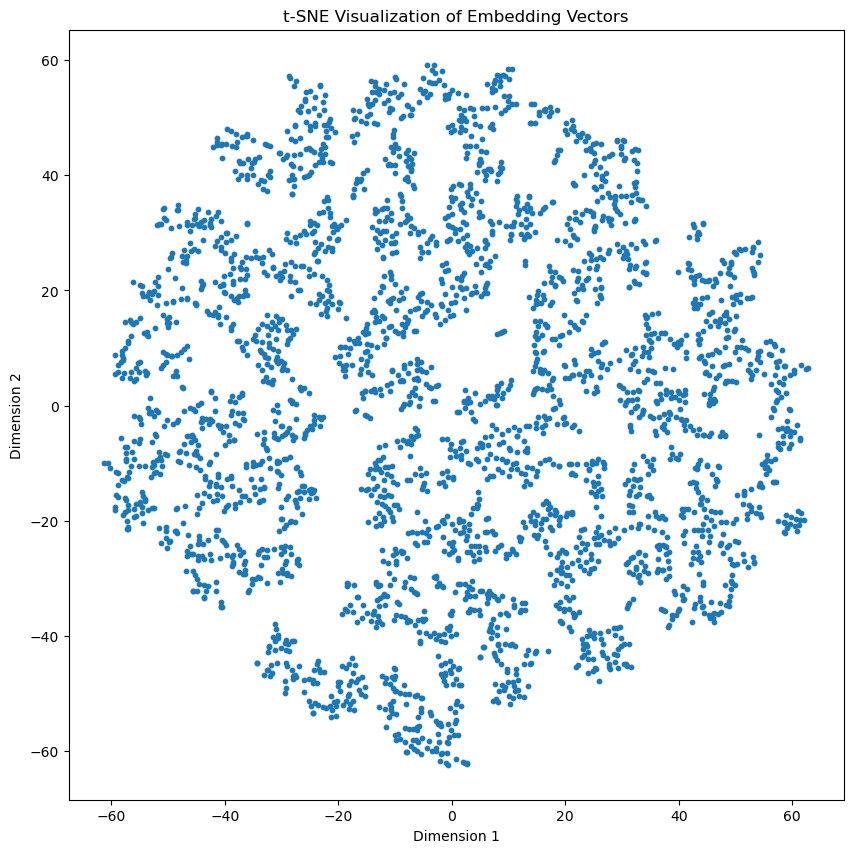

In [37]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
# 예제 데이터 생성


# 임베딩 벡터 추출
embedding_vectors = model.Embedding.weight.data.detach().cpu().numpy()

# t-SNE를 사용한 차원 축소
tsne = TSNE(n_components=2)
embedding_tsne = tsne.fit_transform(embedding_vectors)

# 시각화
plt.figure(figsize=(10, 10))
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], s=10)
plt.title('t-SNE Visualization of Embedding Vectors')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [14]:
model = torch.load('C:/Users/fhsdn/Downloads/Embedding(16).pt')

In [38]:
torch.save(model.state_dict(), 'C:/Users/fhsdn/Downloads/Embedding.pt')